In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import emcee
import os

G = 4.3e-6 # kpc • (km/s)² / M_⊙

In [2]:
def v_plummer(r, M, b):
    return np.sqrt(G * M * r**2 / (r**2 + b**2)**(1.5))

def v_nfw(r, A, r_s):
    r_safe = np.maximum(r, 1e-10)
    r_s_safe = np.maximum(r_s, 1e-10)
    term = (4 * np.pi * G * A) * ((1/r_safe) * np.log(1 + r_safe/r_s_safe) - 1/(r_s_safe + r_safe))
    term = np.maximum(term, 0)
    return np.sqrt(term)

def v_total_model(r, theta):
    A, r_s, M_d, b_d = theta
    v_halo = v_nfw(r, A, r_s)
    v_disk = v_plummer(r, M_d, b_d)
    return np.sqrt(v_halo**2 + v_disk**2)

In [22]:
# def log_prior(theta):
#     # Parametros según el modelo (NFW o ISO)
#     # Suponiendo ISO: [rho0, r_c, M_d, b_d]
#     p1, p2, M_d, b_d = theta 
    
#     # 1. Límites Físicos (Hard bounds)
#     if not (0 < p1 < 1e11 and 0.1 < p2 < 100 and 0 < M_d < 1e12 and 0.1 < b_d < 20):
#         return -np.inf

#     # 2. Prior Informativo para el disco (Soft constraints)
#     # Forzamos b_d a estar cerca de 2.0 kpc con desviación de 1.0 kpc
#     mu_b = 2.0 
#     sigma_b = 1.0
#     log_prob_b = -0.5 * ((b_d - mu_b) / sigma_b)**2
    
#     return log_prob_b

def log_prior(theta):
    A, r_s, M_d, b_d = theta
    
    # Límites generales
    if not (0 < A < 1e12 and 1.0 < r_s < 50 and 0 < M_d < 1e12 and 0.1 < b_d < 20):
        return -np.inf

    # --- CAMBIO CLAVE ---
    # Prior Gaussiano estricto para b_d basado en física
    # F568-3 tiene un disco con escala aproximada de 3-4 kpc.
    mu_b = 3.5 
    sigma_b = 0.5 # Le damos poco margen de maniobra
    
    log_prob_b = -0.5 * ((b_d - mu_b) / sigma_b)**2
    
    return log_prob_b

# Calcula qué tan bien ajusta el modelo a los datos (Chi-cuadrado).
def log_likelihood(theta, r, v_obs, v_err):
    # Verificamos primero el prior para no calcular modelos imposibles
    if not np.isfinite(log_prior(theta)):
        return -np.inf

    v_model = v_total_model(r, theta)
    
    # Chi-squared: sum((obs - model)^2 / err^2)
    # Se añade el término log(err^2) para completitud estadística, aunque es cte aquí.
    sigma2 = v_err**2
    return -0.5 * np.sum((v_obs - v_model)**2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_probability(theta, r, v_obs, v_err):
    # Posterior = Prior + Likelihood
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, v_obs, v_err)

# Encuentra un punto de partida para MCMC con mínimos cuadrados
def get_starting_guess(r, v_obs, v_err):
    def residuals(theta):
        # Penalización suave si se sale de rangos físicos básicos
        if np.any(theta < 0): return np.inf 
        return (v_obs - v_total_model(r, theta)) / v_err

    # A, r_s, M_d, b_d
    initial_guess = [1e7, 10.0, 1e9, 1.5] 
    bounds = ([0, 0, 0, 0.1], [np.inf, 200, np.inf, 50]) # Limites inferiores y superiores
    
    res = least_squares(residuals, initial_guess, bounds=bounds, loss='soft_l1')
    return res.x

def analizar_galaxia(filename):
    base_filename = os.path.basename(filename) 
    galaxy_name = base_filename.split('_')[0]
    
    data = np.loadtxt(f) # Si falla, prueba pd.read_csv con sep='\s+'
    r = data[:, 0]
    v_obs = data[:, 1]
    v_err = data[:, 2]

    # B. Punto de partida (Maximum Likelihood Estimation)
    theta_mle = get_starting_guess(r, v_obs, v_err)
    print(f"Punto de partida (Least Squares):")
    print(f"A={theta_mle[0]:.2e}, rs={theta_mle[1]:.2f}, M_d={theta_mle[2]:.2e}, b_d={theta_mle[3]:.2f}")
    
    # C. Configuración MCMC
    ndim = 4  # A, r_s, M_d, b_d
    nwalkers = 32
    nsteps = 8000
    burn_in = 1000 # Pasos a descartar al inicio

    # Inicializar walkers en una bola pequeña alrededor del resultado de Least Squares
    # pos = theta_mle + 1e-4 * theta_mle * np.random.randn(nwalkers, ndim)
    # Definimos "a mano" un punto de partida donde r_s sea grande
    # A grande, r_s grande (40 kpc), M_d moderado, b_d normal (5 kpc)
    guess_manual = [5e8, 40.0, 1e10, 5.0] 
    # Inicializar walkers alrededor de este punto
    pos = guess_manual + 1e-2 * np.array(guess_manual) * np.random.randn(nwalkers, ndim)
    # Asegurar que la bola inicial esté dentro de los priors (valores positivos)
    pos = np.abs(pos) 
    
    # D. Correr MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r, v_obs, v_err))
    sampler.run_mcmc(pos, nsteps, progress=False)

    # E. Resultados y Visualización
    # Aplanar la cadena y descartar burn-in
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)
    
    labels = [r"A", r"r_s", r"M_d", r"b_d"]

    # F. Reporte Numérico
    print(f"\n--- Resultados {galaxy_name} (Mediana +/- 1 sigma) ---")
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        print(f"{labels[i]}: {mcmc[1]:.3e} (+{q[1]:.3e} / -{q[0]:.3e})")

    # --- CÁLCULO CHI-CUADRADO REDUCIDO ---
    theta_median = np.median(flat_samples, axis=0)
    v_model_best = v_total_model(r, theta_median)
    chi2 = np.sum(((v_obs - v_model_best) / v_err)**2)
    dof = len(r) - ndim
    chi2_red = chi2 / dof
    print(f"Chi^2 reducido: {chi2_red:.3f}")

    # 2. Ajuste vs Datos
    plt.figure(figsize=(6, 4))
    # plt.figure(figsize=(9, 6))
    
    r_plot = np.linspace(0.001, max(r), 150)

    # Cálculo error 1-sigma 
    inds = np.random.randint(len(flat_samples), size=200)
    models = np.array([v_total_model(r_plot, sample) for sample in flat_samples[inds]])
    lower = np.percentile(models, 16, axis=0)
    upper = np.percentile(models, 84, axis=0)

    plt.fill_between(r_plot, lower, upper, color='gray', alpha=0.3, label='Error 1-sigma')
    
    # Datos
    plt.errorbar(r, v_obs, yerr=v_err, fmt=".k", capsize=3, label="Datos")
    
    # Mejor ajuste (mediana)
    plt.plot(r_plot, v_total_model(r_plot, theta_median), "r", lw=2, label="Suma")

    # Componentes individuales (usando la mediana)
    plt.plot(r_plot, v_nfw(r_plot, theta_median[0], theta_median[1]), "b--", label="Halo (NFW)")
    plt.plot(r_plot, v_plummer(r_plot, theta_median[2], theta_median[3]), "g:", label="Disco (Plummer)")

    plt.xlabel("Radio [kpc]")
    plt.ylabel("Velocidad [km/s]")
    plt.title(f"Ajuste curva de rotación de {galaxy_name}")
    # plt.legend(loc='upper left')
    plt.tick_params(direction='in')
    # plt.grid(False, linestyle='--', alpha=0.6)
    plt.savefig(f"mcmc_resultados/{galaxy_name}_fit.pdf", bbox_inches='tight')
    plt.show()

Punto de partida (Least Squares):
A=1.30e+10, rs=12.77, M_d=5.23e+09, b_d=11.39

--- Resultados F563-1 (Mediana +/- 1 sigma) ---
A: 5.722e+10 (+1.838e+10 / -2.003e+10)
r_s: 4.108e+01 (+6.390e+00 / -1.016e+01)
M_d: 7.727e+09 (+4.543e+09 / -3.377e+09)
b_d: 3.948e+00 (+4.731e-01 / -4.624e-01)
Chi^2 reducido: 0.912


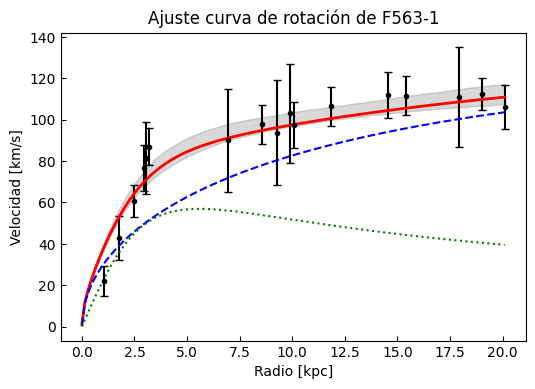

Punto de partida (Least Squares):
A=3.78e+09, rs=6.18, M_d=1.62e+09, b_d=0.93

--- Resultados F563-V2 (Mediana +/- 1 sigma) ---
A: 3.058e+10 (+4.283e+10 / -2.301e+10)
r_s: 3.995e+01 (+7.361e+00 / -1.251e+01)
M_d: 2.402e+10 (+7.510e+09 / -9.016e+09)
b_d: 3.897e+00 (+3.691e-01 / -3.683e-01)
Chi^2 reducido: 0.301


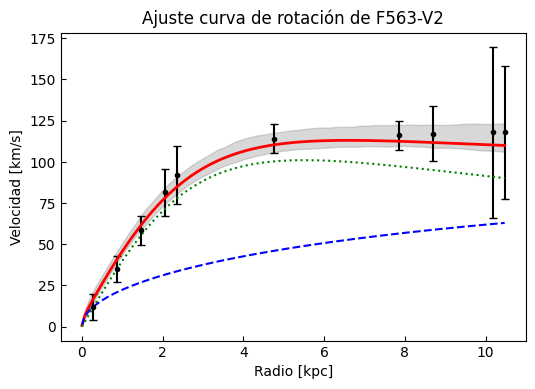

Punto de partida (Least Squares):
A=1.74e+10, rs=13.68, M_d=1.89e+10, b_d=6.82

--- Resultados F568-1 (Mediana +/- 1 sigma) ---
A: 1.127e+11 (+4.772e+10 / -4.752e+10)
r_s: 4.250e+01 (+5.496e+00 / -9.460e+00)
M_d: 9.113e+09 (+9.892e+09 / -5.892e+09)
b_d: 3.972e+00 (+5.184e-01 / -5.095e-01)
Chi^2 reducido: 0.907


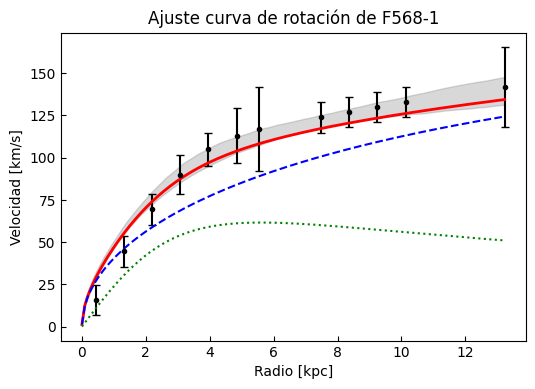

Punto de partida (Least Squares):
A=3.40e+07, rs=0.17, M_d=1.00e+09, b_d=7.72

--- Resultados F568-3 (Mediana +/- 1 sigma) ---
A: 4.216e+10 (+4.349e+10 / -3.474e+10)
r_s: 4.638e+01 (+2.707e+00 / -6.681e+00)
M_d: 1.377e+10 (+1.712e+10 / -1.330e+10)
b_d: 5.735e+00 (+8.385e-01 / -1.787e+00)
Chi^2 reducido: 3.914


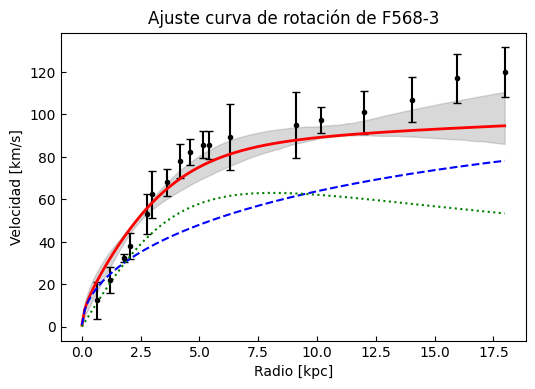

Punto de partida (Least Squares):
A=7.60e+11, rs=200.00, M_d=2.49e+10, b_d=4.43

--- Resultados F568-V1 (Mediana +/- 1 sigma) ---
A: 4.977e+10 (+3.170e+10 / -2.564e+10)
r_s: 3.788e+01 (+8.749e+00 / -1.358e+01)
M_d: 1.510e+10 (+5.973e+09 / -5.212e+09)
b_d: 3.812e+00 (+4.386e-01 / -4.422e-01)
Chi^2 reducido: 0.210


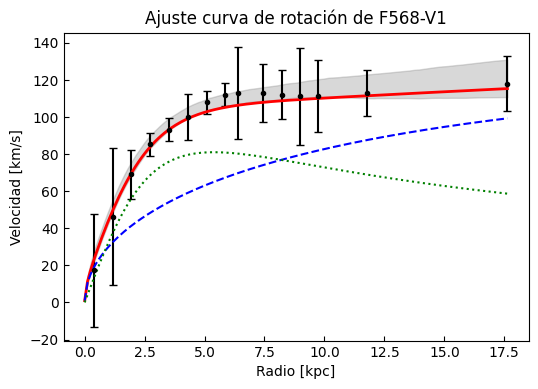

Punto de partida (Least Squares):
A=1.64e+09, rs=2.07, M_d=1.33e+09, b_d=34.43

--- Resultados F571-8 (Mediana +/- 1 sigma) ---
A: 1.419e+11 (+3.119e+10 / -4.025e+10)
r_s: 4.310e+01 (+4.899e+00 / -8.179e+00)
M_d: 5.214e+09 (+4.438e+09 / -3.078e+09)
b_d: 4.139e+00 (+5.409e-01 / -5.256e-01)
Chi^2 reducido: 1.543


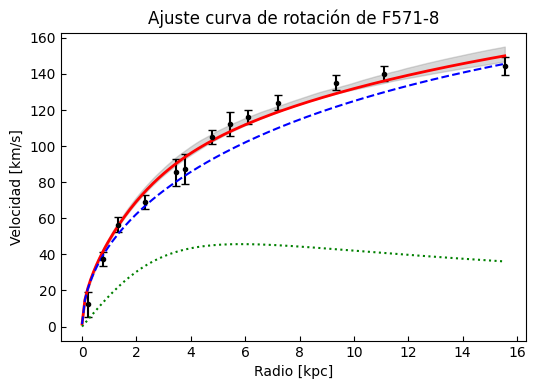

Punto de partida (Least Squares):
A=3.47e+09, rs=5.45, M_d=1.99e+09, b_d=3.96

--- Resultados F574-1 (Mediana +/- 1 sigma) ---
A: 5.150e+10 (+1.671e+10 / -1.814e+10)
r_s: 4.256e+01 (+5.434e+00 / -9.222e+00)
M_d: 9.840e+09 (+3.465e+09 / -2.843e+09)
b_d: 4.181e+00 (+3.967e-01 / -4.051e-01)
Chi^2 reducido: 0.524


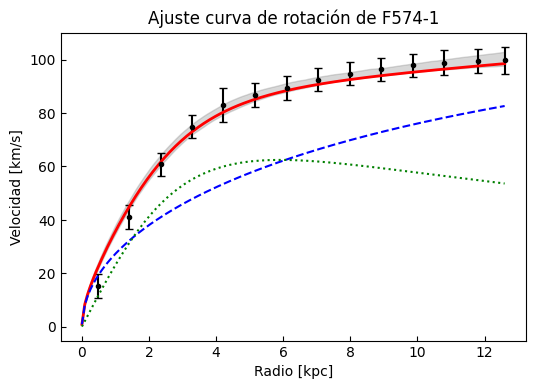

Punto de partida (Least Squares):
A=2.01e+09, rs=2.18, M_d=1.06e+09, b_d=2.82

--- Resultados F579-V1 (Mediana +/- 1 sigma) ---
A: 4.298e+10 (+2.921e+10 / -2.811e+10)
r_s: 3.497e+01 (+1.091e+01 / -1.827e+01)
M_d: 1.363e+10 (+4.506e+09 / -3.911e+09)
b_d: 2.987e+00 (+4.468e-01 / -4.092e-01)
Chi^2 reducido: 0.482


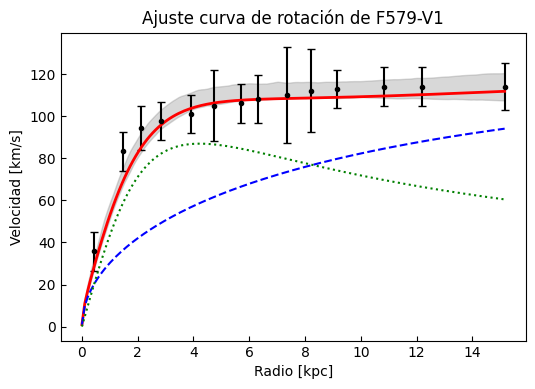

Punto de partida (Least Squares):
A=3.80e+08, rs=1.84, M_d=2.41e+09, b_d=16.11

--- Resultados F583-1 (Mediana +/- 1 sigma) ---
A: 3.785e+10 (+1.274e+10 / -1.282e+10)
r_s: 4.479e+01 (+3.812e+00 / -7.398e+00)
M_d: 6.187e+09 (+3.677e+09 / -2.839e+09)
b_d: 4.856e+00 (+5.209e-01 / -5.356e-01)
Chi^2 reducido: 0.972


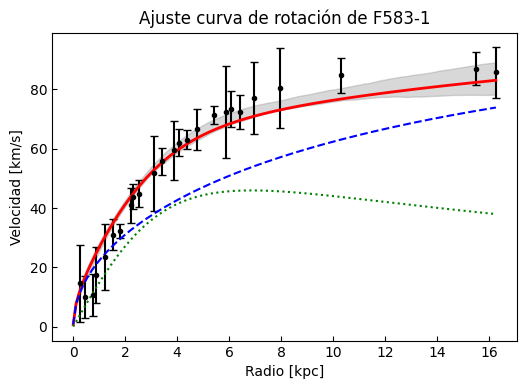

Punto de partida (Least Squares):
A=1.99e+08, rs=0.79, M_d=1.16e+09, b_d=4.25

--- Resultados F583-4 (Mediana +/- 1 sigma) ---
A: 3.112e+10 (+1.885e+10 / -1.721e+10)
r_s: 3.858e+01 (+8.269e+00 / -1.274e+01)
M_d: 2.333e+09 (+2.050e+09 / -1.504e+09)
b_d: 3.513e+00 (+4.693e-01 / -4.530e-01)
Chi^2 reducido: 0.555


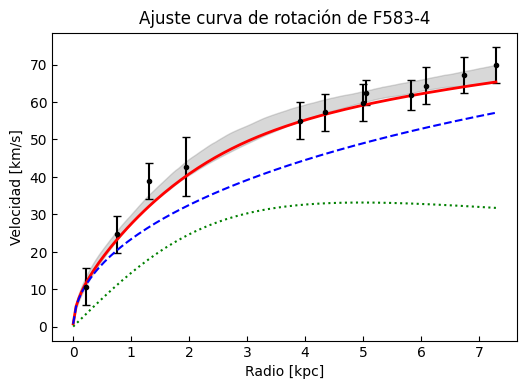

Punto de partida (Least Squares):
A=3.82e+08, rs=4.71, M_d=4.58e+09, b_d=4.98

--- Resultados UGC05750 (Mediana +/- 1 sigma) ---
A: 3.289e+10 (+1.022e+10 / -1.115e+10)
r_s: 4.295e+01 (+5.087e+00 / -8.485e+00)
M_d: 8.445e+08 (+1.181e+09 / -6.221e+08)
b_d: 3.756e+00 (+5.031e-01 / -5.024e-01)
Chi^2 reducido: 1.869


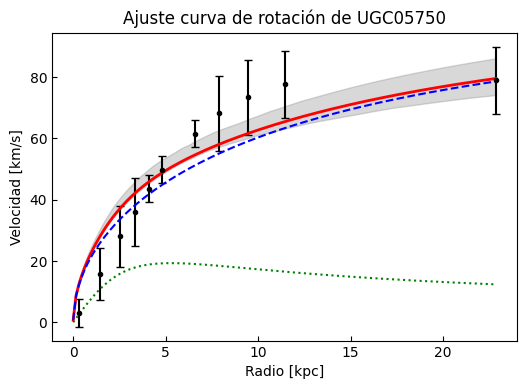

Punto de partida (Least Squares):
A=8.44e+09, rs=3.05, M_d=3.30e+08, b_d=45.47

--- Resultados UGC06614 (Mediana +/- 1 sigma) ---
A: 1.566e+11 (+2.297e+10 / -3.123e+10)
r_s: 4.451e+01 (+4.009e+00 / -6.833e+00)
M_d: 3.472e+10 (+5.882e+09 / -5.820e+09)
b_d: 2.857e+00 (+4.440e-01 / -4.315e-01)
Chi^2 reducido: 0.614


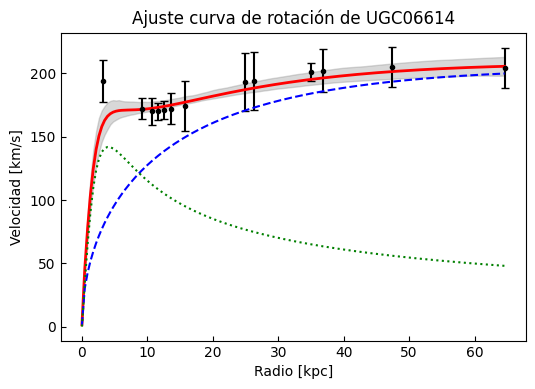

In [23]:
if __name__ == "__main__":
    archivos = [
    'data_lsb/F563-1_rotmod.dat',
    'data_lsb/F563-V2_rotmod.dat',
    'data_lsb/F568-1_rotmod.dat',
    'data_lsb/F568-3_rotmod.dat',
    'data_lsb/F568-V1_rotmod.dat',
    'data_lsb/F571-8_rotmod.dat',
    'data_lsb/F574-1_rotmod.dat',
    'data_lsb/F579-V1_rotmod.dat',
    'data_lsb/F583-1_rotmod.dat',
    'data_lsb/F583-4_rotmod.dat',
    'data_lsb/UGC05750_rotmod.dat',
    'data_lsb/UGC06614_rotmod.dat'
    ]
    
    for f in archivos:
        if os.path.exists(f):
            analizar_galaxia(f)
        else:
            print(f"Archivo {f} no encontrado.")